In [1]:
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import esm

# takes FASTA files and generates dataframe and csv with descriptions and features

In [145]:
df = pd.read_csv("seq_df_first_10000_less_1000.csv", index_col=0).dropna()
cols = list(df.columns)
print(cols)

['Sequence', 'Name', 'Description', 'Length', 'Num_Features', 'Molecular Weight', 'Aromaticity', 'Instability Index', 'Flexibility', 'GRAVY', 'Isoelectric Point', 'Charge at pH:7.0']


In [146]:
sort_feature = "Molecular Weight"
assert sort_feature in cols, "Feature not in df.columns"
df = df.sort_values(by=sort_feature, ascending=False)

In [147]:
df.head()

,Sequence,Name,Description,Length,Num_Features,Molecular Weight,Aromaticity,Instability Index,Flexibility,GRAVY,Isoelectric Point,Charge at pH:7.0
ID,,,,,,,,,,,,
UniRef50_UPI001ABDBAD4,EREKKEREREEREREREEREREREEREREERERKREREEREREERE...,UniRef50_UPI001ABDBAD4,UniRef50_UPI001ABDBAD4 trichohyalin-like n=1 T...,478,0,67379.7753,0.000000,101.190795,"[1.0737380952380955, 1.0552380952380953, 1.085...",-4.000837,11.023465,86.317066
UniRef50_A0A7R9FCU9,KEYCYFSTSQSLDIDYLHVAQAAQFCSAHFTSILYVELWSSEQIKE...,UniRef50_A0A7R9FCU9,UniRef50_A0A7R9FCU9 Uncharacterized protein (F...,463,0,61628.6454,0.412527,95.673240,"[0.9677619047619048, 0.9975, 0.976892857142857...",-0.913607,6.132780,-13.983200
UniRef50_A0A8J7RNY4,MKKDYSDYKPTKNEIYNLNRSDRENVRLKYFYNYARFSKDDKRIHI...,UniRef50_A0A8J7RNY4,UniRef50_A0A8J7RNY4 EF-hand domain-containing ...,497,0,59346.4374,0.142857,49.837062,"[1.051797619047619, 1.0363214285714288, 1.0007...",-0.854527,6.677809,-0.944757
UniRef50_A0A4Q9LJS8,MNTYELFRSRIYQVLDTKNIVYQKSDIDLEINDDDIYEFKRYLNIW...,UniRef50_A0A4Q9LJS8,UniRef50_A0A4Q9LJS8 3'5'-cyclic nucleotide pho...,490,0,59309.7513,0.151020,43.624367,"[0.9606666666666667, 0.9839523809523809, 1.000...",-0.314490,9.240721,26.567350
UniRef50_UPI003776A4C8,MKKVKRFLFRNVYIKWLERDFNKKLELLEEFRLRKHVQAVIEENSE...,UniRef50_UPI003776A4C8,UniRef50_UPI003776A4C8 class 1 isoprenoid bios...,495,0,58931.1116,0.129293,51.186909,"[0.990857142857143, 0.9771428571428573, 0.9828...",-0.288081,5.273374,-20.948914


### Exploratory Data Analysis

Text(0.5, 1.0, 'Distribution of GRAVY values')

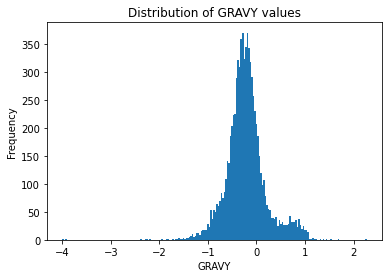

In [148]:
plt.hist(df["GRAVY"], bins=200)
plt.xlabel("GRAVY")
plt.ylabel("Frequency")
plt.title("Distribution of GRAVY values")

Text(0.5, 1.0, 'Distribution of Aromaticity values')

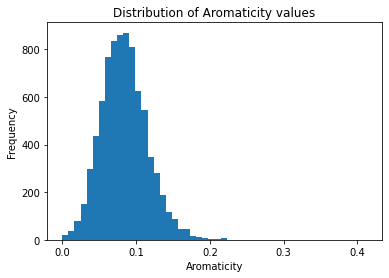

In [149]:
plt.hist(df["Aromaticity"], bins=50)
plt.xlabel("Aromaticity")
plt.ylabel("Frequency")
plt.title("Distribution of Aromaticity values")

Text(0.5, 1.0, 'Distribution of MW values')

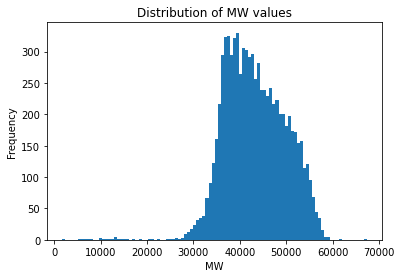

In [150]:
plt.hist(df["Molecular Weight"], bins=100)
plt.xlabel("MW")
plt.ylabel("Frequency")
plt.title("Distribution of MW values")

Text(0.5, 1.0, 'Distribution of Charge at pH:7.0 values')

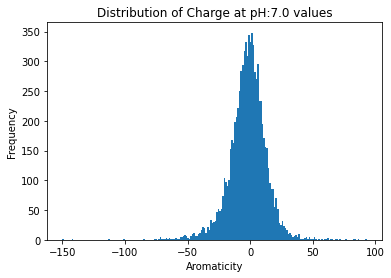

In [151]:
plt.hist(df["Charge at pH:7.0"], bins=200)
plt.xlabel("Aromaticity")
plt.ylabel("Frequency")
plt.title("Distribution of Charge at pH:7.0 values")

### Load Model

In [155]:
# Load ESM-2 model
#model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()
model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t30_150M_UR50D.pt" to /Users/davidm/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t30_150M_UR50D-contact-regression.pt" to /Users/davidm/.cache/torch/hub/checkpoints/esm2_t30_150M_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 640, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (q_proj): Linear(in_features=640, out_features=640, bias=True)
        (out_proj): Linear(in_features=640, out_features=640, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=640, out_features=2560, bias=True)
      (fc2): Linear(in_features=2560, out_features=640, bias=True)
      (final_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (

In [156]:
def get_features(data, model):    
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[6], return_contacts=True)
    token_representations = results["representations"][6]
    # Generate per-sequence representations via averaging
    # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
    sequence_representations = []
    for i, tokens_len in enumerate(batch_lens):
        sequence_representations.append(token_representations[i, 1 : tokens_len - 1].mean(0).numpy())
    results['sequence_representations'] = np.array(sequence_representations)
    # Look at the unsupervised self-attention map contact predictions
    # import matplotlib.pyplot as plt
    # for (_, seq), tokens_len, attention_contacts in zip(data, batch_lens, results["contacts"]):
    #     plt.matshow(attention_contacts[: tokens_len, : tokens_len])
    #     plt.title(seq[:10] + "...")
    #     plt.colorbar()
    #     plt.show()    
    return results

In [159]:
top_gravy = df.iloc[:10]
low_gravy = df.iloc[-10:]

top_gravy_X = [(top_gravy.iloc[i]["Name"], top_gravy.iloc[i]["Sequence"]) for i in range(len(top_gravy))]
low_gravy_X = [(low_gravy.iloc[i]["Name"], low_gravy.iloc[i]["Sequence"]) for i in range(len(low_gravy))]
top_gravy_X, low_gravy_X

([('UniRef50_UPI001ABDBAD4',
   'EREKKEREREEREREREEREREREEREREERERKREREEREREEREKRERERRKRERRKRERRKREREEREREEREKKEREKKERERRKREREEREREEREREEREREEREREEREREKKEREKKERERRKRERRKRERRKREERRKREREKKKREREKKEREKKEREKKERERRKRERREREEREREEREREKKERERRKRERRKREREEREREERERERKKERRKRERRKREREKKERERRKREREREEREREKKEREKREREEREREKKERERRKRERRKREREKKEREREERERERRKRERRKRERERRKRERRKREREEREREEREREEERRKRERRKREREEREREEREREEREREERERRKRERRKRERERRKRERRKRERRKRERRKREREERERERRKRERERRKRERRKRERRKREREEREREEREKKEREKKERERRKREREEREREEREREEREREEREREERERE'),
  ('UniRef50_A0A7R9FCU9',
   'KEYCYFSTSQSLDIDYLHVAQAAQFCSAHFTSILYVELWSSEQIKEHPSIIVGDNVSPLDCICDKDPERGRDVEDILREAYTRLQYKDAVSGCGSSYLLDSLTRVSHLELEGQWEQAMQEYQLHSKNDDPTAIQGLCRCLHRMGSHNLLHRYLAATEKTSELLAIQYECGWRLGQWDLGRCPQGDLYEGHHYDALQATEEGDLARARLSLSRARICVAATALAHASLESAMNLYPSLSRLQTLQELEDFLNDNPLNQDSMKYYYYYHYYYHYYYYYYYYYYYYYYYYYYYYYHYYYHYYYYHYYYYYYYYYYYYYYYYYYYYYYYYHYYYYYYYHYYYYYYYYYYHYYYYHHYYYHYYYHYYHYYYYYYYYYYHYYYYHYYYHYYYNHHYYYYHHYYHHHYYYHYYYHYYYHYYYYYYYYYYYYYYYYYYFYYYYHYYYYYHYYYYYYYCHYYYC

In [160]:
# this can take a while...
top_gravy_results = get_features(top_gravy_X, model)
low_gravy_results = get_features(low_gravy_X, model)

In [164]:
res_high = dict(top_gravy_results)
print(res_high.keys())
res_low = dict(low_gravy_results)
print(res_low.keys())

dict_keys(['logits', 'representations', 'attentions', 'contacts', 'sequence_representations'])
dict_keys(['logits', 'representations', 'attentions', 'contacts', 'sequence_representations'])


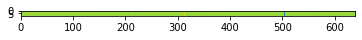

In [165]:
sr_high = res_high['sequence_representations'] # top feature representations
plt.imshow(sr_high)

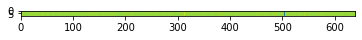

In [166]:
sr_low = res_low['sequence_representations'] # top feature representations
plt.imshow(sr_low)

### Visuals

In [167]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [168]:
sr_high = sr_high[:]
sr_high_std = sr_high - sr_high.mean(axis=0)
sr_high_std /= sr_high_std.std(axis=0)

sr_low = sr_low[:]
sr_low_std = sr_low - sr_low.mean(axis=0)
sr_low_std /= sr_low_std.std(axis=0)

In [169]:
pca = PCA(n_components=3)

sr_high_pca = pca.fit_transform(sr_high_std)
sr_low_pca = pca.fit_transform(sr_low_std)

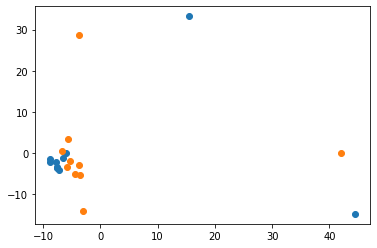

In [170]:
plt.scatter(sr_high_pca[:, 0], sr_high_pca[:, 1])
plt.scatter(sr_low_pca[:, 0], sr_low_pca[:, 1])

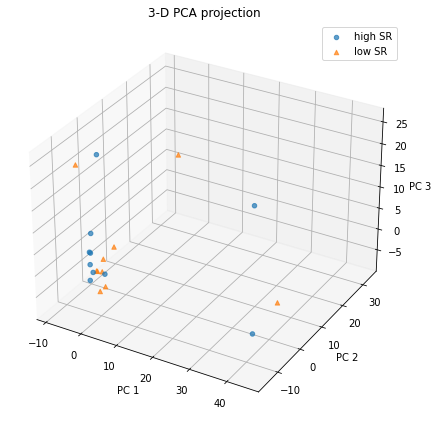

In [179]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

# 3-D scatter for the two classes
ax.scatter(
    sr_high_pca[:, 0], sr_high_pca[:, 1], sr_high_pca[:, 2],
    s=20, alpha=0.7, label="high SR", marker="o"
)
ax.scatter(
    sr_low_pca[:, 0], sr_low_pca[:, 1], sr_low_pca[:, 2],
    s=20, alpha=0.7, label="low SR",  marker="^"
)

# Axis labels (use real explained-variance % if you have pca.explained_variance_ratio_)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

ax.legend(loc="best")
ax.set_title("3-D PCA projection")
plt.tight_layout(); plt.show()

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1.086893
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.857567


/Users/davidm/opt/anaconda3/envs/esmfold/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 1100 iterations: 2.217350
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 10 samples in 0.000s...
[t-SNE] Computed neighbors for 10 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 10 / 10
[t-SNE] Mean sigma: 1.130382


/Users/davidm/opt/anaconda3/envs/esmfold/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.786453
[t-SNE] KL divergence after 2000 iterations: 0.701047


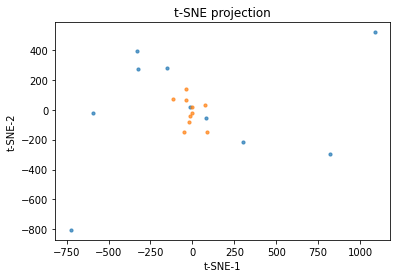

In [178]:
tsne = TSNE(
    n_components     = 3,      # 2-D for plotting (use 3 for 3-D)
    perplexity       = 1,     # “effective #neighbors” (5–50 typical)
    learning_rate    = "auto", # or a value ~ n_samples / 12
    init             = "pca",  # pca|random; pca gives stabler layouts
    n_iter           = 2000,   # 250–1000 is common; more for cleaner structure
    metric           = "euclidean",
    random_state     = 0,
    verbose          = 1
)
Z = tsne.fit_transform(sr_high_std)    
Z_2 = tsne.fit_transform(sr_low_std) # shape (n_samples, 2)

# 4) Visualise  ---------------------------------------------------------
plt.scatter(Z[:,0], Z[:,1], s=10, alpha=0.7)
plt.scatter(Z_2[:,0], Z_2[:,1], s=10, alpha=0.7)
plt.title("t-SNE projection"); plt.xlabel("t-SNE-1"); plt.ylabel("t-SNE-2"); plt.show()

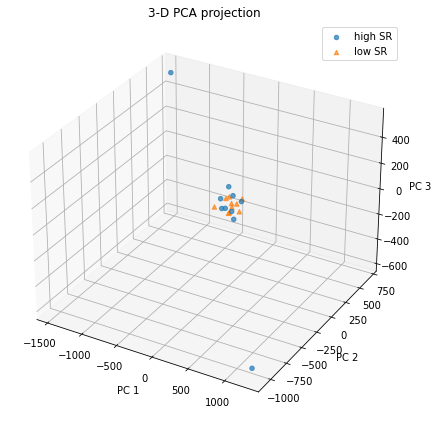

In [173]:
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection="3d")

# 3-D scatter for the two classes
ax.scatter(
    Z[:, 0], Z[:, 1], Z[:, 2],
    s=20, alpha=0.7, label="high SR", marker="o"
)
ax.scatter(
    Z_2[:, 0], Z_2[:, 1], Z_2[:, 2],
    s=20, alpha=0.7, label="low SR",  marker="^"
)

# Axis labels (use real explained-variance % if you have pca.explained_variance_ratio_)
ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")

ax.legend(loc="best")
ax.set_title("3-D PCA projection")
plt.tight_layout(); plt.show()